## Fake News Classification

In [ ]:
!pip install keras --upgrade

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt

from keras import layers
from keras import losses
import keras
from keras import utils

from keras.layers import TextVectorization

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

# for embedding viz
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

#pio.renderers.default='iframe'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Source
Our data for this assignment comes from the article
 - Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).

## 1. Acquire Training Data
The dataset hosted a training data set at the below URL.

In [4]:
# import the training dataset
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
df = pd.read_csv(train_url)

Each row of the data corresponds to an article. The `title` column gives the title of the article, while the `text` column gives the full article text. The final column, called `fake`, is 0 if the article is true and 1 if the article contains fake news, as determined by the authors of the paper above.

Let's take a quick look:

In [ ]:
# check dataframe
df.head()

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


## 2. Make a Dataset
Write a function called `make_dataset`. This function should do three things:

1. Change the text to lowercase.
2. *Remove stopwords* from the article `text` and `title`. A stopword is a word that is usually considered to be uninformative, such as “the,” “and,” or “but.”
3. Construct and return a `tf.data.Dataset` with two inputs and one output. The input should be of the form `(title, text)`, and the output should consist only of the `fake` column.

Call the function `make_dataset` on your training dataframe to produce a `tf.data.Dataset`. You may wish to `batch` your `Dataset` prior to returning it, which can be done like this: `my_data_set.batch(100)`. Batching causes your model to train on chunks of data rather than individual rows. This can sometimes reduce accuracy, but can also greatly increase the speed of training. Finding a balance is key. I found batches of 100 rows to work well.

In [5]:
def make_dataset(df):

  """
  Prepares a TensorFlow dataset from a pandas DataFrame by processing text data.
  The function converts text to lowercase, removes English stopwords, and batches
  the inputs and outputs.

  Parameters:
  df (pandas.DataFrame): DataFrame with 'title', 'text', and 'fake' columns.

  Returns:
  tf.data.Dataset: A batched dataset with tuples of inputs and outputs.
  """

  ## Change all text to lowercase
  df['text'] = df['text'].str.lower()
  df['title'] = df['title'].str.lower()

  ## Remove stopwords
  # stopwords from nltk
  stop = stopwords.words('english')
  pattern = r'\b(' + '|'.join(stop) + r')\b' # use regex
  # remove stopwords through replacement
  df['text'] = df['text'].str.replace(pattern, '', regex=True)
  df['title'] = df['title'].str.replace(pattern, '', regex=True)

  # Convert the DataFrame columns to Tensors
  titles = tf.convert_to_tensor(df['title'].values)
  texts = tf.convert_to_tensor(df['text'].values)
  fake = tf.convert_to_tensor(df['fake'].values)

  # Combine the titles and texts into a single input tensor
  inputs = (titles, texts)

  # Create a tf.data.Datasetfrom the input and output tensors
  dataset = tf.data.Dataset.from_tensor_slices((inputs, fake))

  # Batch the dataset
  batched_dataset = dataset.batch(100)

  return batched_dataset

### Validation Data
After you’ve constructed your primary `Dataset`, split it into two parts, where 80% is used for training and 20% of it to use for validation.

In [6]:
# Construct the primary Dataset
Dataset = make_dataset(df)

In [7]:
# Determine the total number of batches in the full dataset
total_batches = len(df) // 100  # if batch_size is 100

# Calculate the number of batches to take for validation
val_batches = int(total_batches * 0.2)

# The validation dataset will be the first 20% of the dataset
val = Dataset.take(val_batches)

# The rest will be the training dataset
train = Dataset.skip(val_batches)

### Base Rate
 The base rate refers to the accuracy of a model that always makes the same guess (for example, such a model might always say “fake news!”). Determine the base rate for this data set by examining the labels on the training set.

In [ ]:
fake_count = df['fake'].sum() # count the number of `fake` labels
true_count = len(df) - fake_count # count the number of `true` labels

print(f"This is the number of 'fake' labels: {fake_count}")
print(f"This is the number of 'true' labels: {true_count}")

This is the number of 'fake' labels: 11740
This is the number of 'true' labels: 10709


In [ ]:
# base model will always guess `fake` because it occurs more frequently
# Calculate the base accuracy:
print(f'The base accuracy for the full dataset is {fake_count / (fake_count + true_count)}')

The base accuracy for the full dataset is 0.522963160942581


In [ ]:
# Unbatch the dataset
unbatched = train.unbatch()

# This mapping function now simply returns the label because it's a scalar tensor
unbatched = unbatched.map(lambda x, label: label)

# Cast to numpy iterator then to list
np_data = list(unbatched.as_numpy_iterator())

# Calculate the mean of the labels - we can do this because it's binary
mean_label = np.mean(np_data)

print(f'The training base accuracy is {mean_label}')

The training base accuracy is 0.524239570059283


The base accuracy is around 52%, and we see that this is true for both the full dataset and the training dataset.

### TextVectorization

Text vectorization is a process in natural language processing that turns text into numerical data so that machine learning models can process it. The `TextVectorization` layer in TensorFlow automates this by assigning a unique integer to each word and standardizing the text, like converting to lowercase and removing punctuation. This prepares the text for the model to learn from the patterns within.

In [8]:
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    """
    Standardize the input text data by converting to lowercase and removing punctuation.
    
    Args:
    input_data: A Tensor of type string.
    
    Returns:
    A Tensor of the same shape as `input_data`, with text standardized.
    """
    lowercase = tf.strings.lower(input_data)
    # Remove specific unwanted character (right single quotation mark)
    no_special_char = tf.strings.regex_replace(lowercase, u'\u2019', '')
    no_punctuation = tf.strings.regex_replace(no_special_char,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

# TextVectorize the titles and text
vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

# same layer learns abt common words in the text
vectorize_layer.adapt(train.map(lambda x, y: x[1]))

## 3. Create Models
Please use TensorFlow models to offer a perspective on the following question:

> When detecting fake news, is it most effective to focus on only the title of the article, the full text of the article, or both?

### First Model
In the first model, we will use only the article title as an input.

The code below sets up a neural network with `keras` to classify text by creating separate input layers for article titles and text content, vectorizing the titles, applying an embedding layer to capture semantic meaning, using dropout for regularization, and averaging the features. A dense layer then processes these features for binary classification of the text.

In [9]:
## Create the title and text inputs

title_input = keras.Input(
    shape = (1,), # only a single title in each
    name = 'title',
    dtype = 'string'
)

text_input = keras.Input(
    shape = (1,), # only a single text in each
    name = 'text',
    dtype = 'string'
)

In [10]:
# use functional APIs to assemble model
title_features = vectorize_layer(title_input) # vectorize title input
title_features = layers.Embedding(size_vocabulary, output_dim = 3, name="embedding1")(title_features) # capture semantic meaning and relationship b/w words
title_features = layers.Dropout(0.2)(title_features) #Dropout for overfitting
title_features = layers.GlobalAveragePooling1D()(title_features) # spatial averaging over the entire dimension
title_features = layers.Dropout(0.2)(title_features) #Dropout for overfitting
title_features = layers.Dense(32, activation='relu')(title_features) # 32 neurons

title_output = layers.Dense(2, name = "fake")(title_features) # final binary classification

Now we will put all the layers into one cohesive model and display the summary.

In [11]:
# put everything into a model
model1 = keras.Model(
      inputs = title_input,
      outputs = title_output
)

model1.summary() # summarize model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ title (InputLayer)                   │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 500)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding1 (Embedding)               │ (None, 500, 3)              │           6,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 500, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 3)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fake (Dense)                         │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,194 (24.20 KB)

 Trainable params: 6,194 (24.20 KB)

 Non-trainable params: 0 (0.00 B)

Now we will visualize all the layers in our first model:

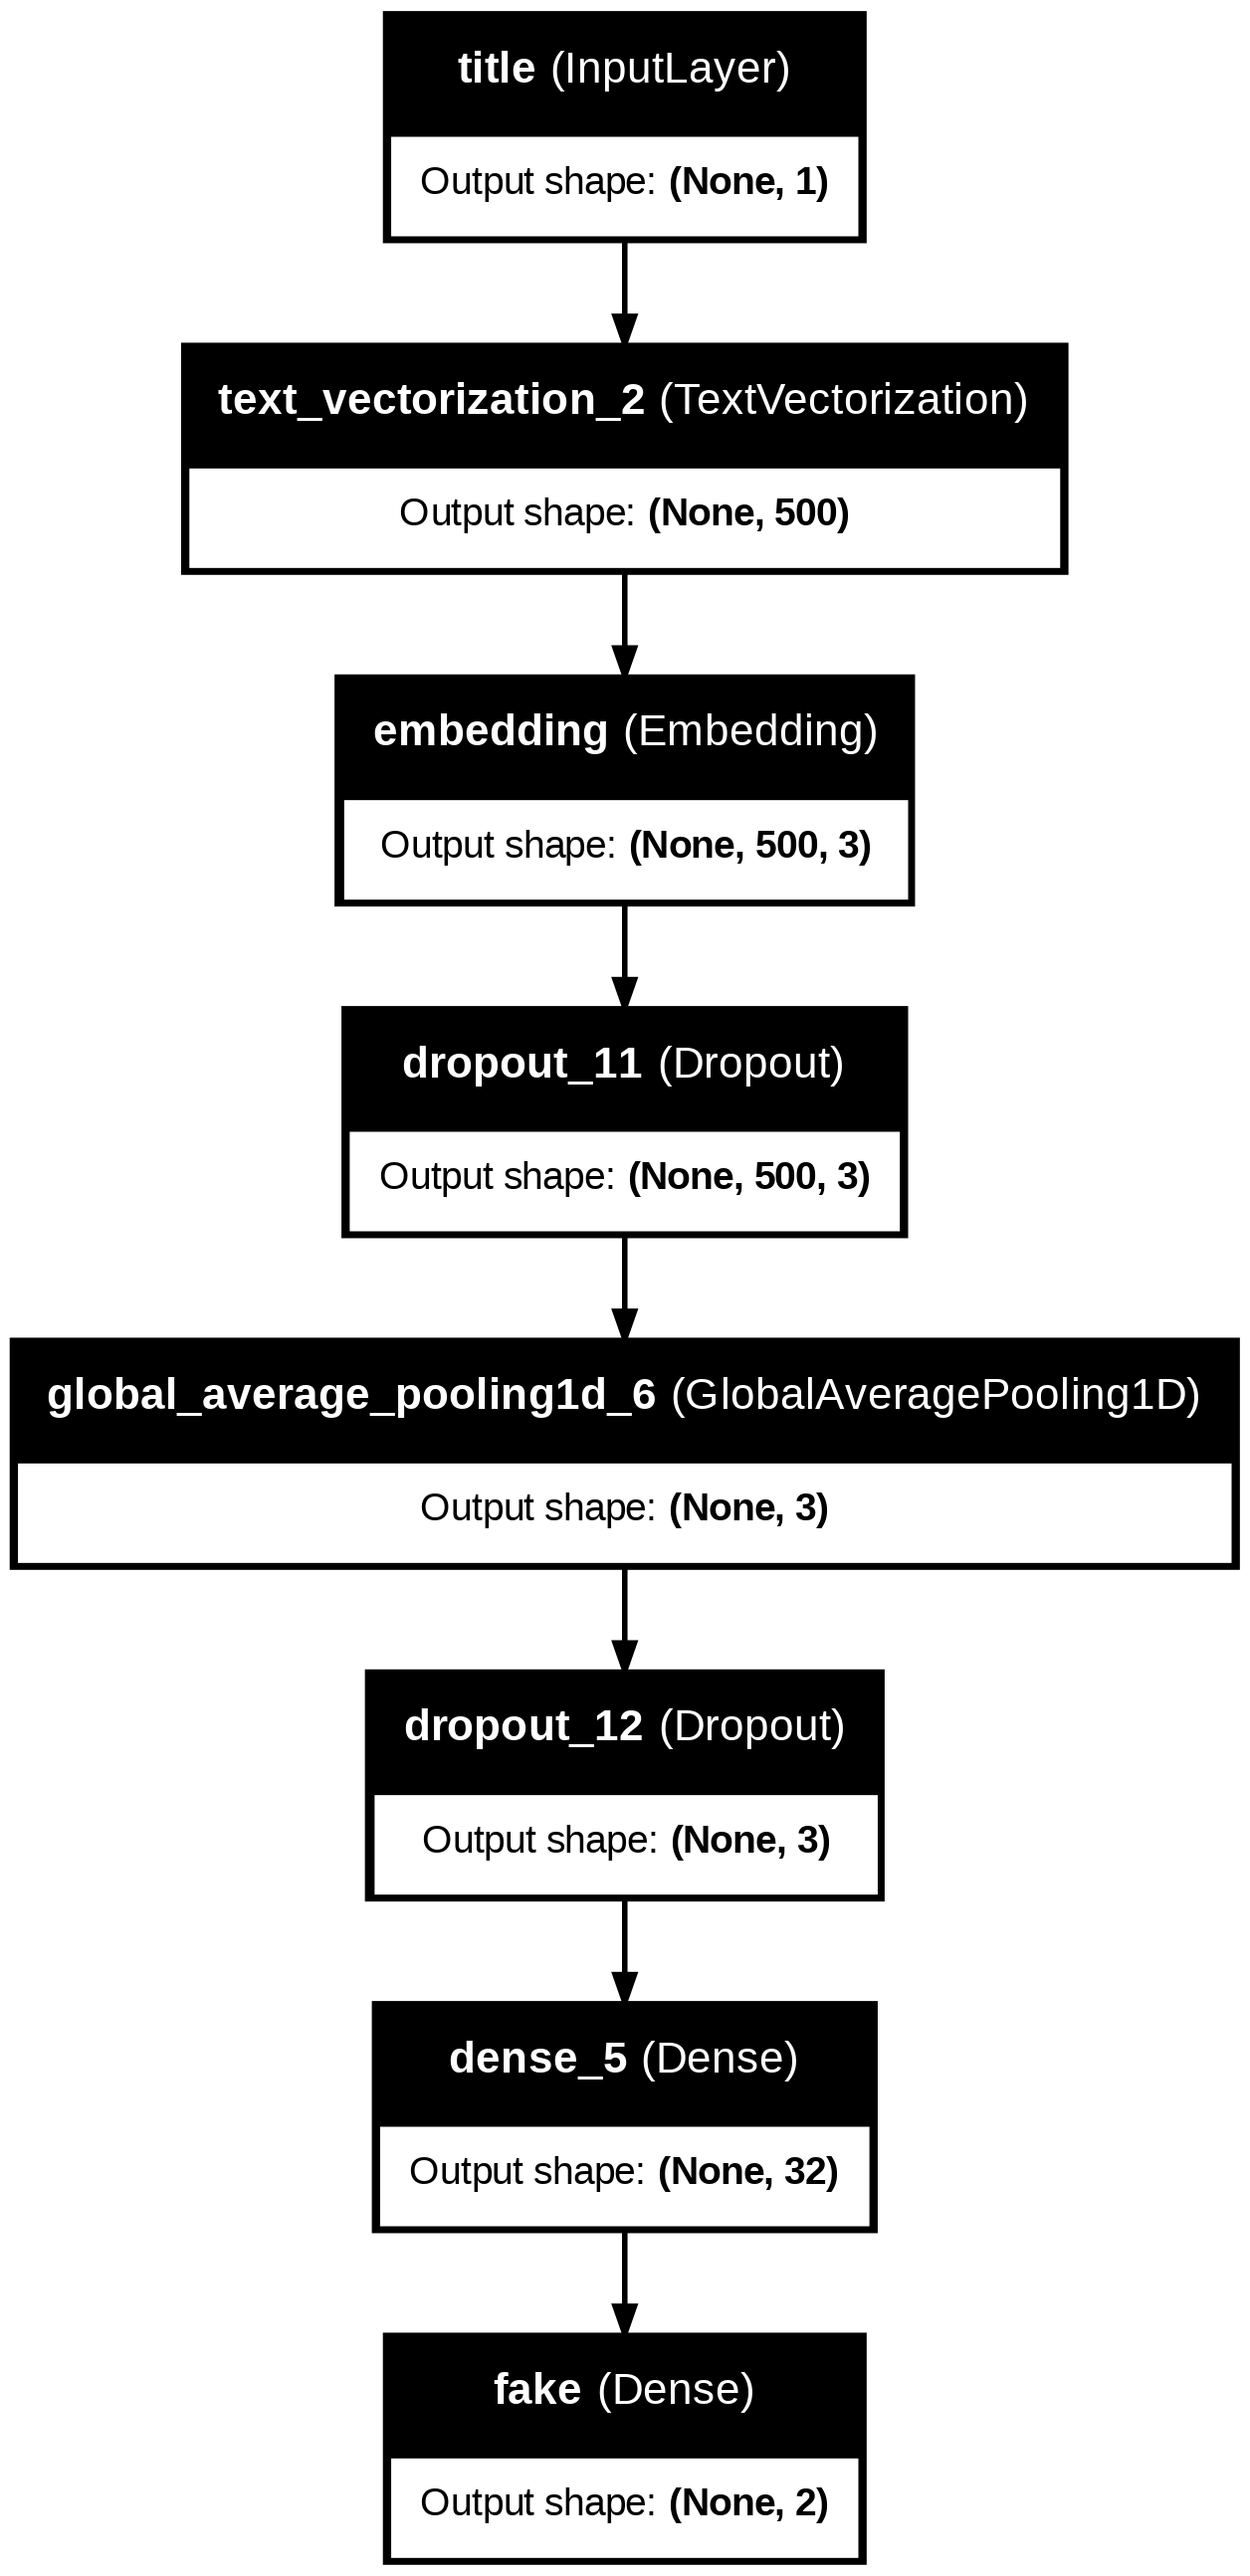

In [ ]:
# visualize model
utils.plot_model(model1, "output1_filename.png",
                       show_shapes=True,
                       show_layer_names=True)

Now we will compile the model and train it:

In [ ]:
# compile the model
model1.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
# train the model
history1 = model1.fit(train.map(lambda x, y: (x[0], y)), # only take the title as input
                    validation_data=val.map(lambda x, y: (x[0], y)), # only take the title as input
                    epochs = 20)

Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5216 - loss: 0.6924 - val_accuracy: 0.5177 - val_loss: 0.6904
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5309 - loss: 0.6895 - val_accuracy: 0.7520 - val_loss: 0.6781
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6158 - loss: 0.6688 - val_accuracy: 0.7518 - val_loss: 0.6109
Epoch 4/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6934 - loss: 0.5979 - val_accuracy: 0.6705 - val_loss: 0.5640
Epoch 5/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7349 - loss: 0.5299 - val_accuracy: 0.7798 - val_loss: 0.4777
Epoch 6/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7526 - loss: 0.5016 - val_accuracy: 0.7886 - val_loss: 0.4558
Epoch 7/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7597 - loss: 0.4891 - val_accuracy: 0.7945 - val_loss: 0.4401
Epoch 8/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7697 - loss: 0.4739 - val_accuracy: 0.

**The validation accuracy just based on title alone is around 87% to 88%.**
I added 2 `Dropout` layers to combat overfitting, and since the validation accuracy is slightly higher than the training accuracy, overfitting is definitely not an issue.

Now we will plot the accuracy metrics:

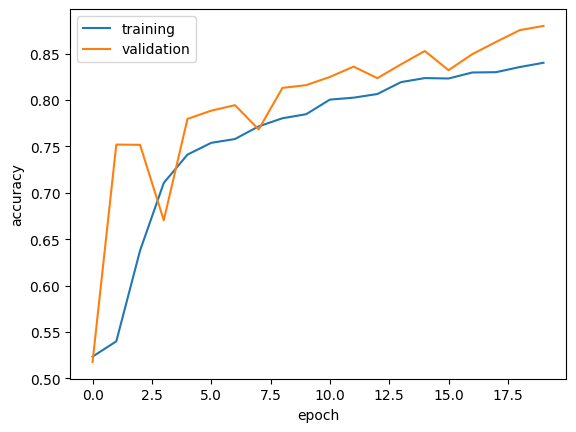

In [ ]:
#plot accuracy metrics
plt.plot(history1.history["accuracy"], label = "training")
plt.plot(history1.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

## Second Model
In the second model, we will only use the article text as an input.

The code constructs a neural network model that processes text data for binary classification. It includes layers for text vectorization, embedding, dropout to mitigate overfitting, pooling to condense features, and dense layers for learning, culminating in a binary output.

In [12]:
# use functional APIs
text_features = vectorize_layer(text_input) # vectorize the text
text_features = layers.Embedding(size_vocabulary, output_dim = 3, name="embedding2")(text_features) # capture semantic meaning and relationship b/w words
text_features = layers.Dropout(0.2)(text_features) #Dropout for overfitting
text_features = layers.GlobalAveragePooling1D()(text_features) # spatial averaging over the entire dimension
text_features = layers.Dropout(0.2)(text_features) #Dropout for overfitting
text_features = layers.Dense(32, activation='relu')(text_features) # 32 neurons

text_output = layers.Dense(2, name = "fake")(text_features) # final binary classification

Now we will put all the layers into one cohesive model and display the summary:

In [13]:
# put everything into a model
model2 = keras.Model(
      inputs = text_input,
      outputs = text_output
)

model2.summary() # summarize model

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)                    │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 500)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding2 (Embedding)               │ (None, 500, 3)              │           6,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 3)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fake (Dense)                         │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,194 (24.20 KB)

 Trainable params: 6,194 (24.20 KB)

 Non-trainable params: 0 (0.00 B)

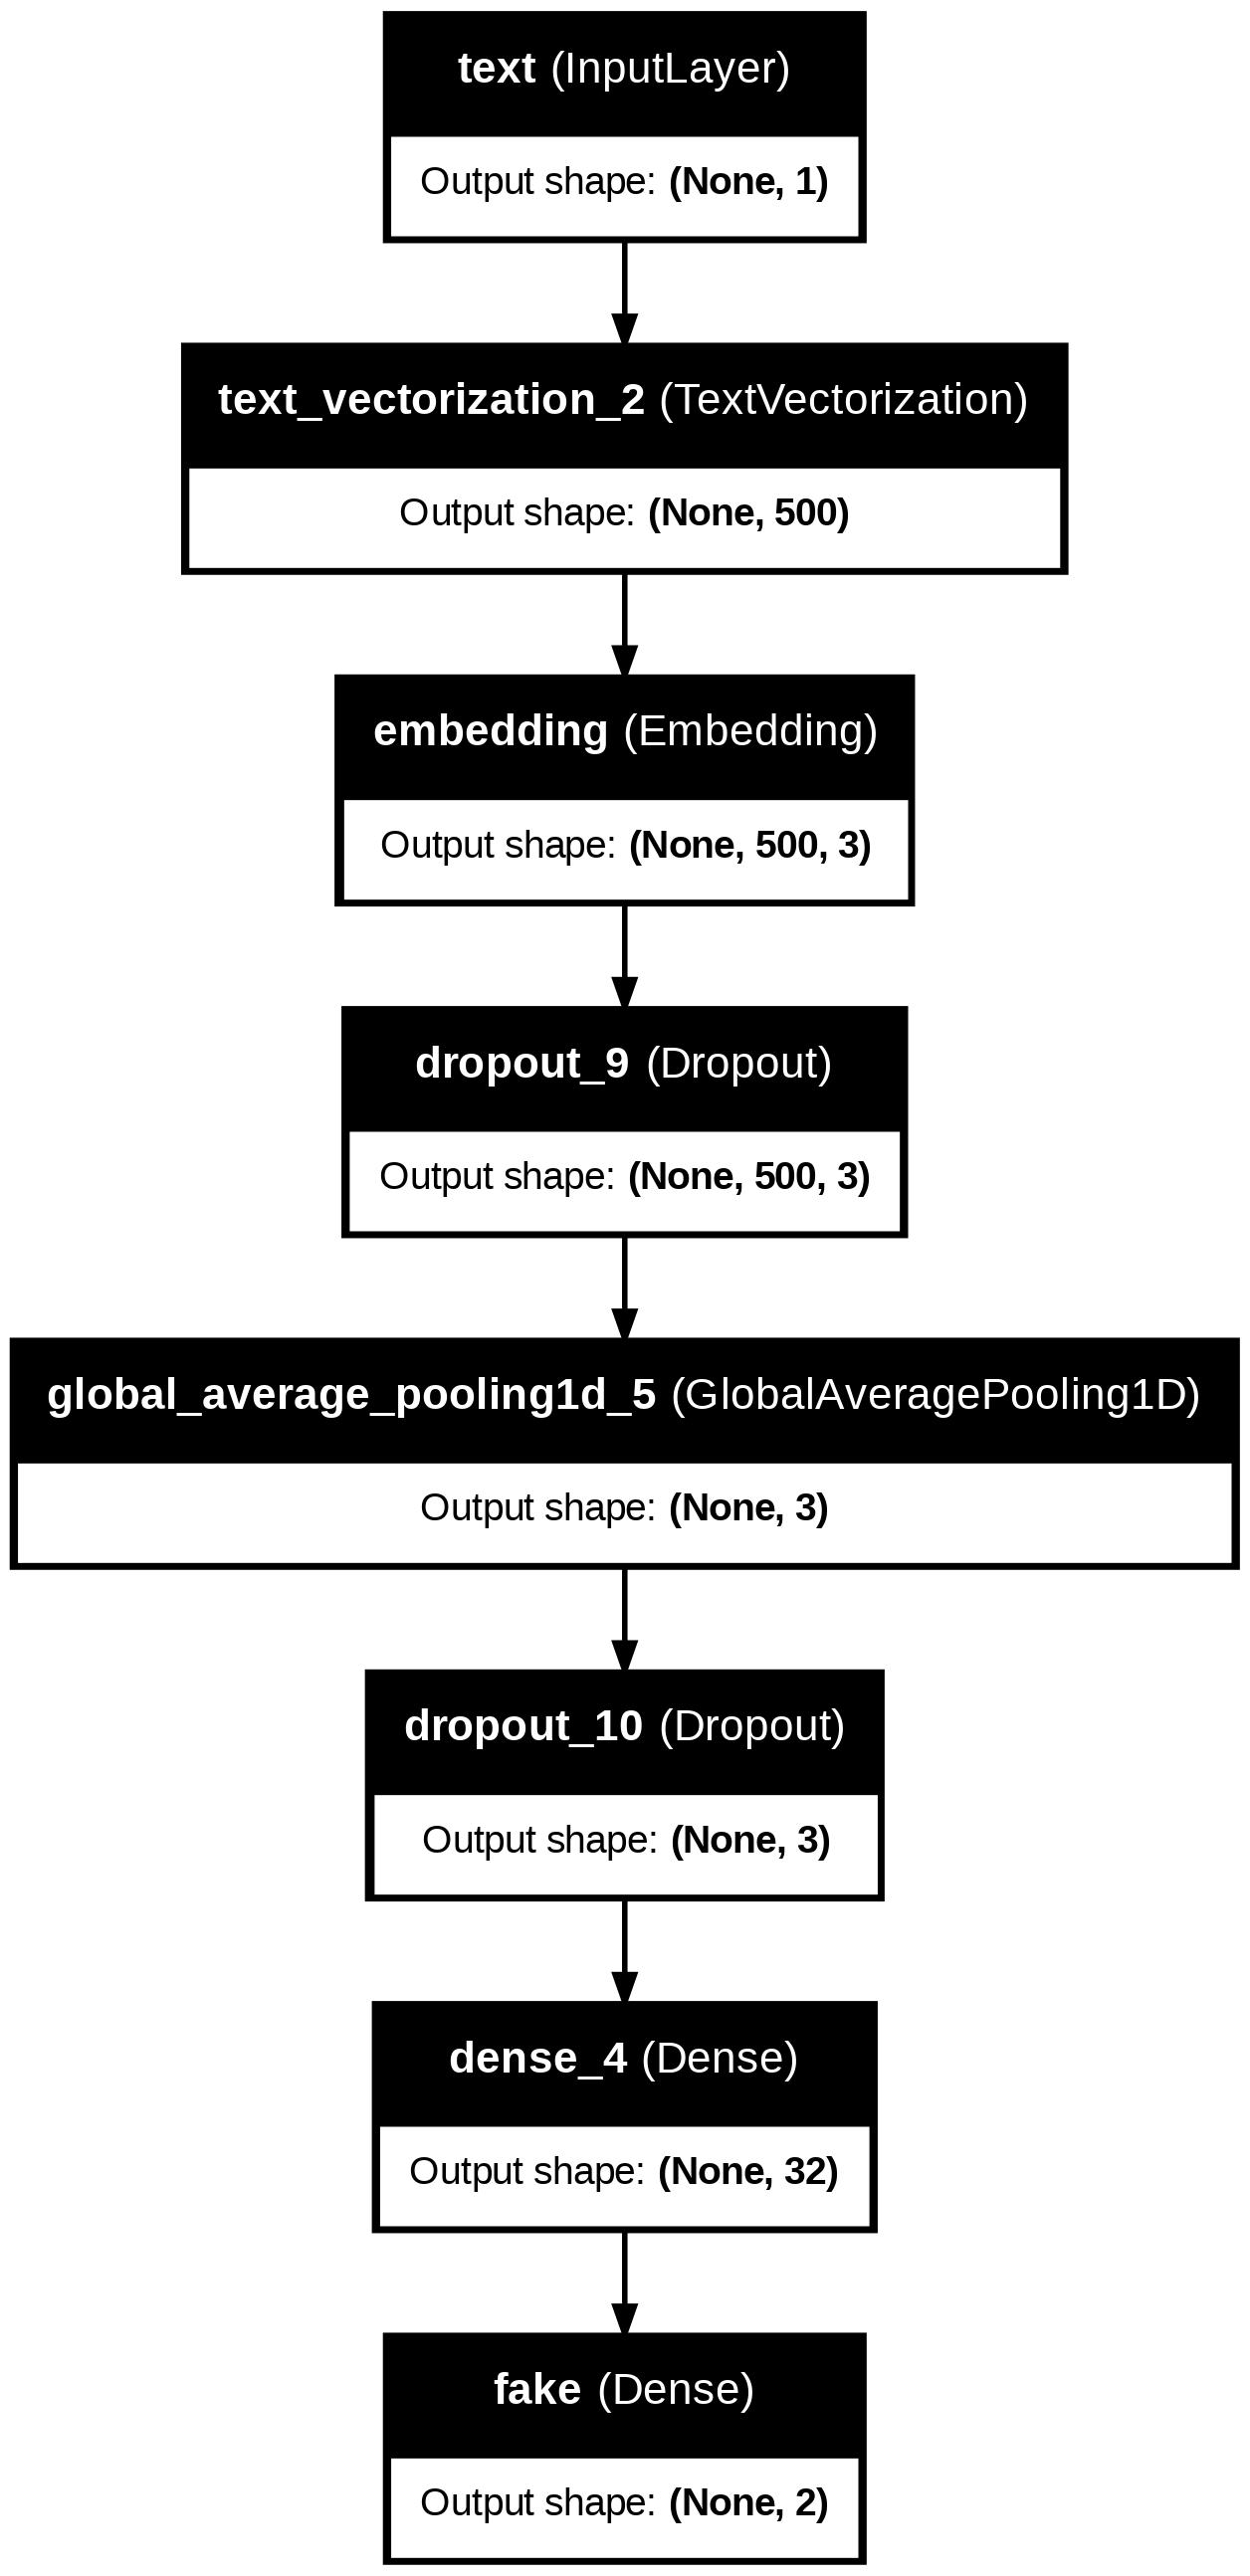

In [ ]:
# visualize model
utils.plot_model(model2, "output2_filename.png",
                       show_shapes=True,
                       show_layer_names=True)

Now we will compile the model and train it:

In [ ]:
# compile the model
model2.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
# train the model
history2 = model2.fit(train.map(lambda x, y: (x[1], y)), # only take the text as input
                    validation_data=val.map(lambda x, y: (x[1], y)), # only take the text as input
                    epochs = 20)

Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5440 - loss: 0.6858 - val_accuracy: 0.9286 - val_loss: 0.5790
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8603 - loss: 0.4902 - val_accuracy: 0.9407 - val_loss: 0.2658
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9278 - loss: 0.2552 - val_accuracy: 0.9480 - val_loss: 0.1943
Epoch 4/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9340 - loss: 0.1987 - val_accuracy: 0.9532 - val_loss: 0.1696
Epoch 5/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9405 - loss: 0.1736 - val_accuracy: 0.9523 - val_loss: 0.1566
Epoch 6/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9472 - loss: 0.1615 - val_accuracy: 0.9570 - val_loss: 0.1464
Epoch 7/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9514 - loss: 0.1481 - val_accuracy: 0.9600 - val_loss: 0.1398
Epoch 8/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9519 - loss: 0.1407 - val_accu

**The validation accuracy just based on text alone is above 96%.** Once again, overfitting is not an issue.

Now we will plot the accuracy metrics:

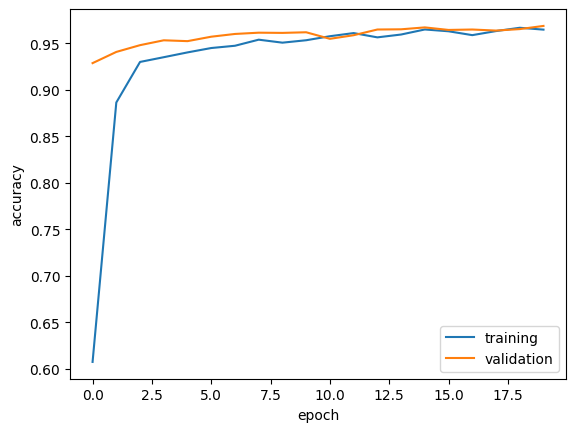

In [ ]:
#plot accuracy metrics
plt.plot(history2.history["accuracy"], label = "training")
plt.plot(history2.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

## Third Model
In the third model, We will use both the article title and the article text as input.

It combines the feature representations of the title and the text using concatenation, then processes this combined data through a dense layer with ReLU activation, and finally outputs the result through a binary classification layer.

In [14]:
# combine both text and title and will require us to concatenate our prior two pipelines:
both = layers.concatenate([title_features, text_features], axis=1)
# add another final dense layer
both = layers.Dense(32, activation='relu')(both)
both_output = layers.Dense(2, name="fake")(both)

Now we will put all the layers into one cohesive model and display the summary:

In [15]:
model3 = keras.Model(
    inputs = [title_input, text_input],
    outputs = both_output
)
model3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ title (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 500)            │              0 │ title[0][0],           │
│ (TextVectorization)       │                        │                │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding1 (Embedding)    │ (None, 500, 3)         │          6,000 │ text_vectorization[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding2 (Embedding)    │ (None, 500, 3)         │          6,000 │ text_vectorization[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 500, 3)         │              0 │ embedding1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 500, 3)         │              0 │ embedding2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 3)              │              0 │ dropout[0][0]          │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 3)              │              0 │ dropout_2[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 3)              │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 3)              │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            128 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │            128 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64)             │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fake (Dense)              │ (None, 2)              │             66 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,402 (56.26 KB)

 Trainable params: 14,402 (56.26 KB)

 Non-trainable params: 0 (0.00 B)

Now we will visualize the model:

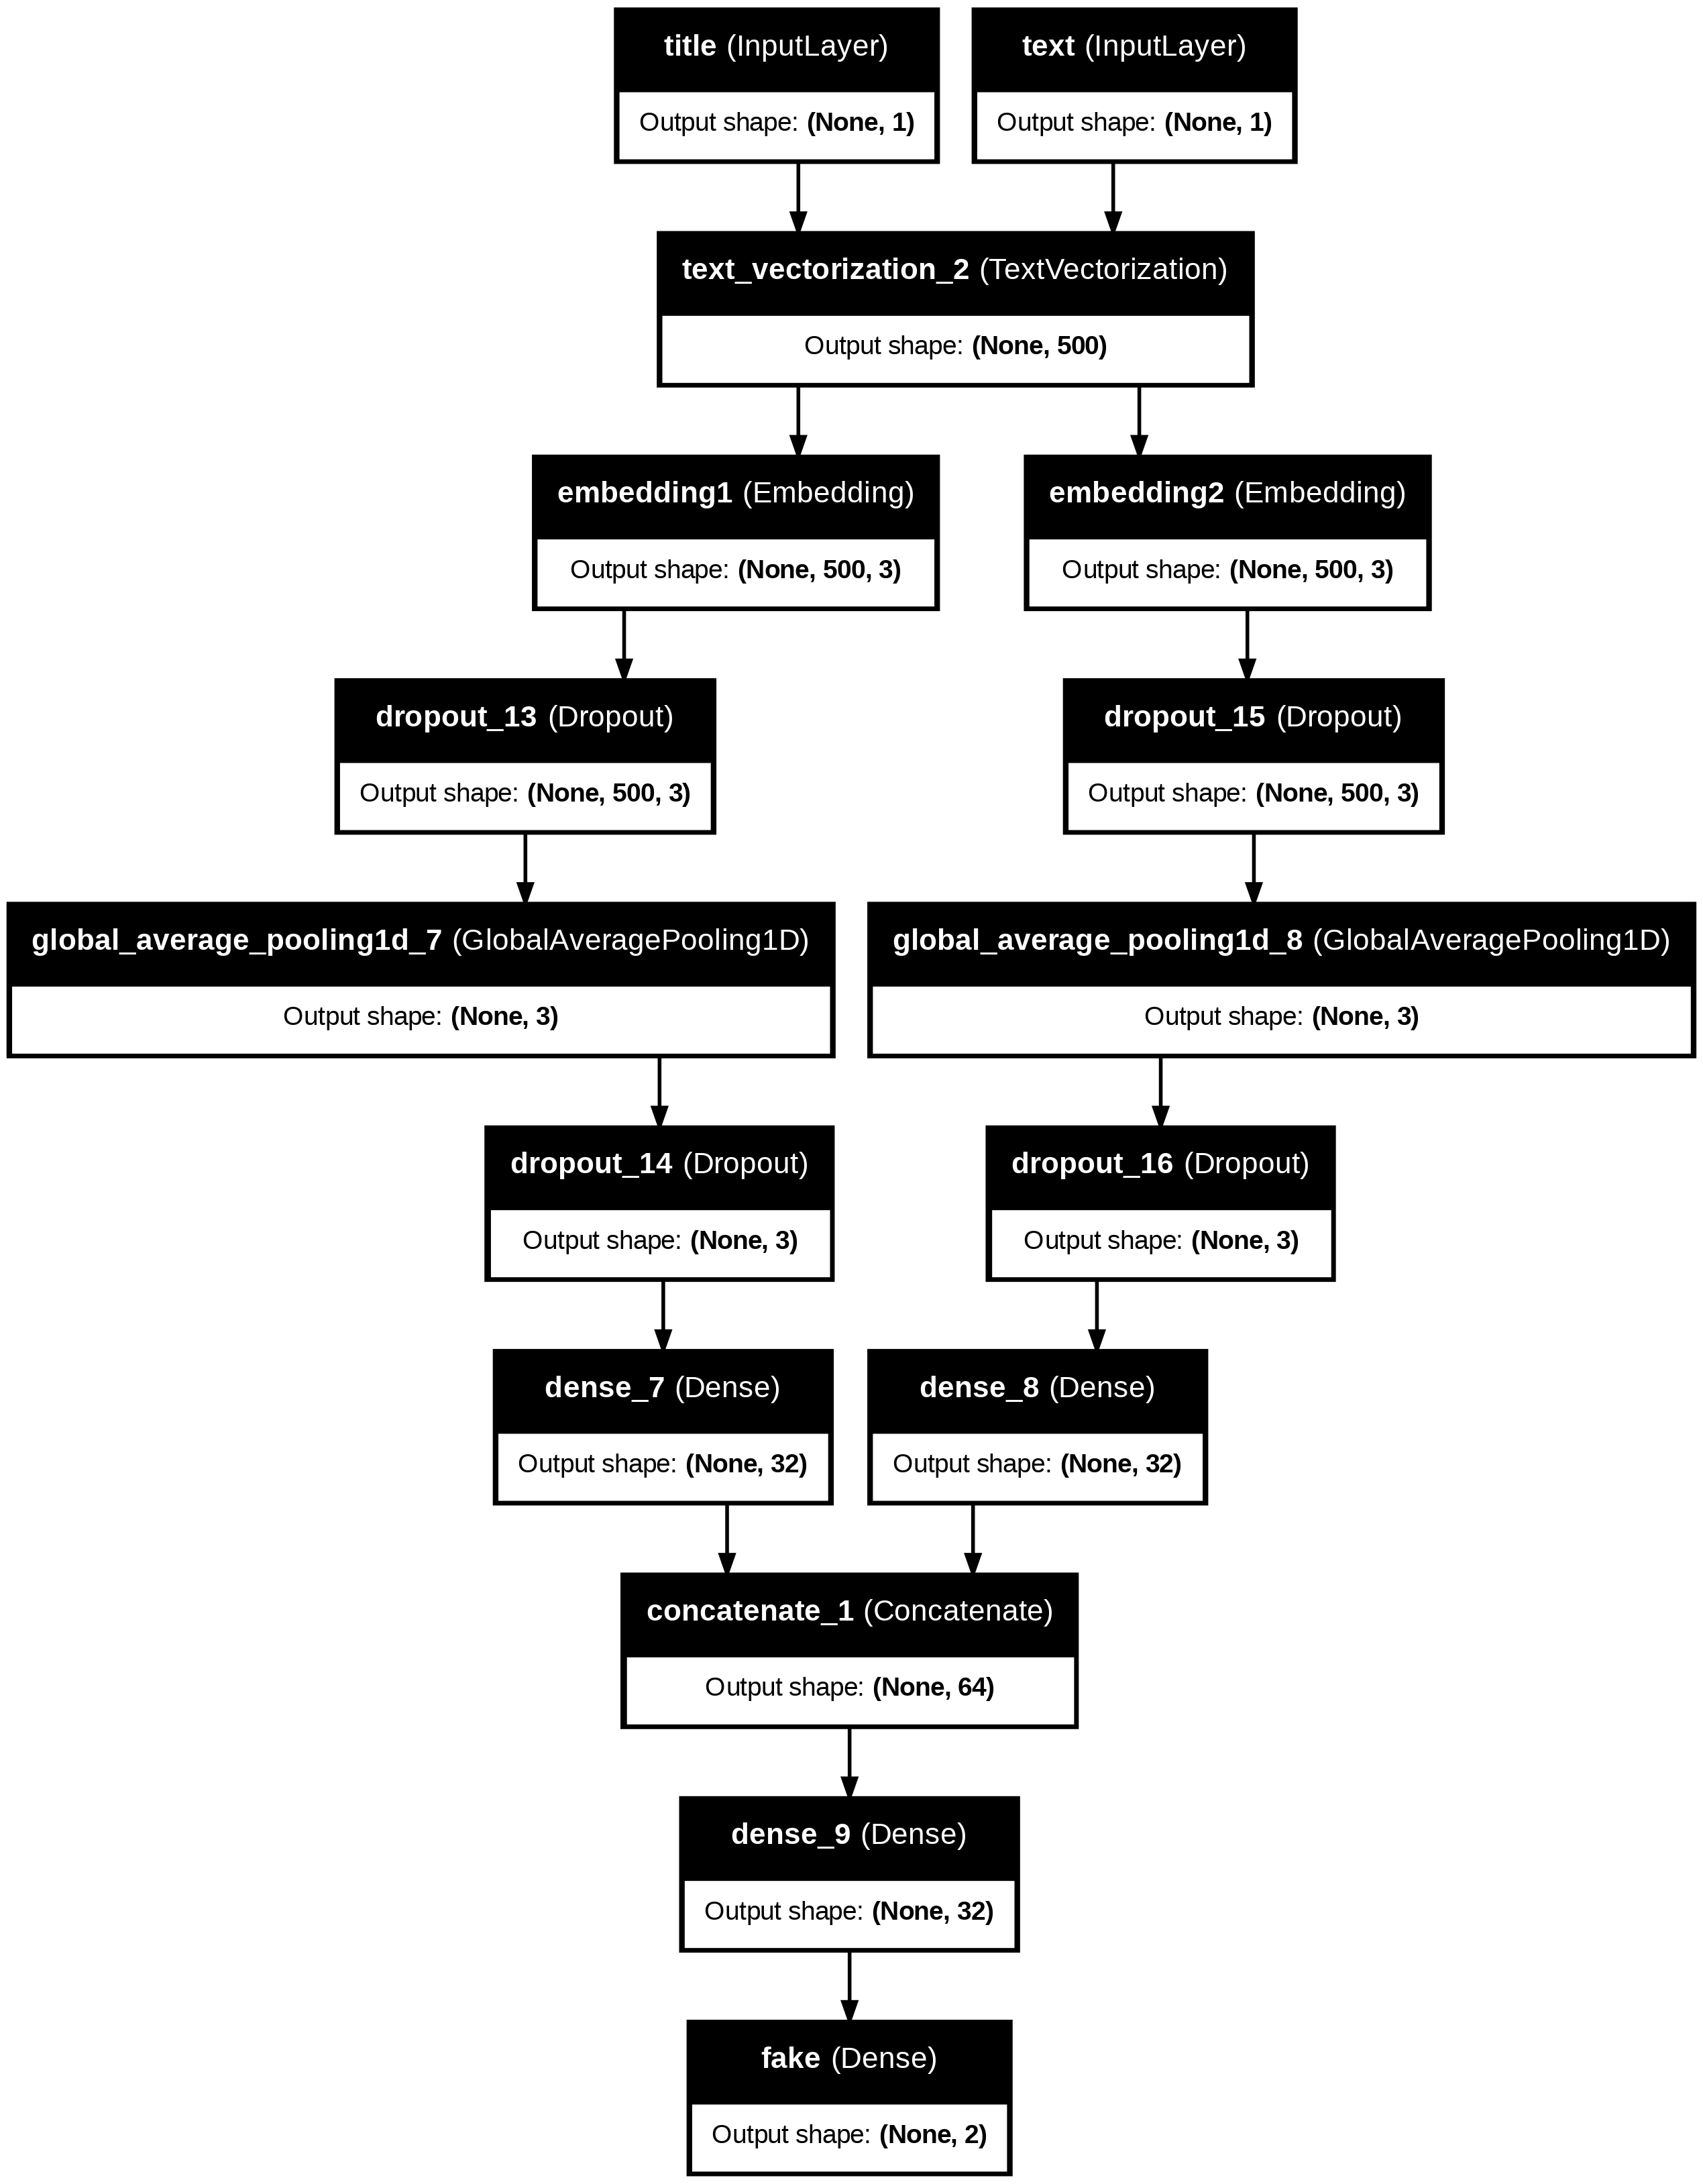

In [ ]:
# visualize model
utils.plot_model(model3, "output3_filename.png",
                       show_shapes=True,
                       show_layer_names=True)

Now we will compile the model and train it:

In [ ]:
# compile the model
model3.compile(optimizer="adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
# train the model
history3 = model3.fit(train, # only take the text as input
                    validation_data=val, # only take the text as input
                    epochs = 20)

Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9669 - loss: 0.0916 - val_accuracy: 0.9725 - val_loss: 0.0978
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9713 - loss: 0.0804 - val_accuracy: 0.9743 - val_loss: 0.0912
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9742 - loss: 0.0780 - val_accuracy: 0.9739 - val_loss: 0.0885
Epoch 4/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9716 - loss: 0.0799 - val_accuracy: 0.9723 - val_loss: 0.0895
Epoch 5/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9674 - loss: 0.0908 - val_accuracy: 0.9757 - val_loss: 0.0884
Epoch 6/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9773 - loss: 0.0658 - val_accuracy: 0.9730 - val_loss: 0.0907
Epoch 7/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9732 - loss: 0.0744 - val_accuracy: 0.9764 - val_loss: 0.0825
Epoch 8/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9709 - loss: 0.0792 - val_accu

**The validation accuracy just based on both title and text is above 97%.** Once again, overfitting is not an issue.

Now we will plot the accuracy metrics:

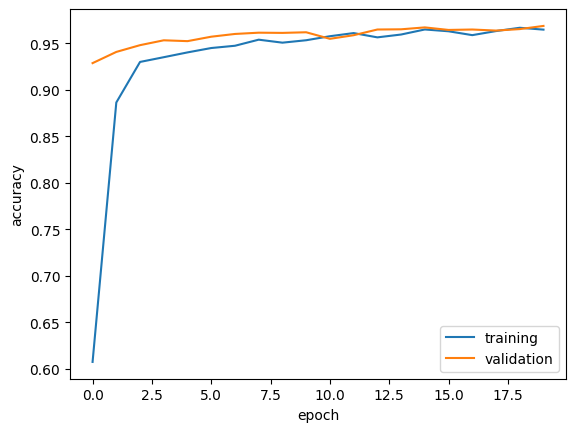

In [ ]:
#plot accuracy metrics
plt.plot(history2.history["accuracy"], label = "training")
plt.plot(history2.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

Overall, the third model using both title and text performed the best at around/above 97%. The second model was not far off behind at around/above 96%, while the first model performed the worst, stabilizing between 87% and 88%. Therefore, ideally, we would use both the title and text for the algorithm.

## 4. Model Evaluation

To evaluate our model against our test data, we will donwload it from the link below.

In [16]:
# download test data
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
test_df = pd.read_csv(test_url)
test_df

,Unnamed: 0,title,text,fake
0,420,"CNN And MSNBC Destroy Trump, Black Out His Fa...",Donald Trump practically does something to cri...,1
1,14902,Exclusive: Kremlin tells companies to deliver ...,The Kremlin wants good news. The Russian lead...,0
2,322,Golden State Warriors Coach Just WRECKED Trum...,"On Saturday, the man we re forced to call Pre...",1
3,16108,"Putin opens monument to Stalin's victims, diss...",President Vladimir Putin inaugurated a monumen...,0
4,10304,BREAKING: DNC HACKER FIRED For Bank Fraud…Blam...,Apparently breaking the law and scamming the g...,1
...,...,...,...,...
22444,20058,U.S. will stand be steadfast ally to Britain a...,The United States will stand by Britain as it ...,0
22445,21104,Trump rebukes South Korea after North Korean b...,U.S. President Donald Trump admonished South K...,0
22446,2842,New rule requires U.S. banks to allow consumer...,U.S. banks and credit card companies could be ...,0
22447,22298,US Middle Class Still Suffering from Rockefell...,Dick Eastman The Truth HoundWhen Henry Kissin...,1


We then need to preprocess our test data. 

In [ ]:
# preprocess the test data
test_ds = make_dataset(test_df)

After preprocessing, we can now evaulate it!

In [ ]:
# test it
model3.evaluate(test_ds)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9731 - loss: 0.0887


[0.08659978955984116, 0.973985493183136]

The accuracy is slightly above 97%, which is what we are aiming for!

## 4. Embedding Visualizations

The code retrieves the learned weights from two embedding layers corresponding to title and text. To facilitate visualization, it uses Principal Component Analysis (PCA) from the sklearn library to reduce the dimensionality of these weights to two components. This reduction allows for plotting in a two-dimensional space, which can help in understanding and interpreting the relationships and clustering of words based on their learned embeddings.

In [17]:
# Retrieve the weights from the first embedding layer (for the title)
weights_1 = model3.get_layer('embedding1').get_weights()[0]

# Retrieve the weights from the second embedding layer (for the text)
weights_2 = model3.get_layer('embedding2').get_weights()[0]

# Retrieve the shared vocabulary from the vectorization layer
vocab = vectorize_layer.get_vocabulary()

In [18]:
from sklearn.decomposition import PCA
# Combine the weights from both embedding layers if necessary
# Perform PCA to reduce to 2 components
pca_1 = PCA(n_components=2)
weights_1 = pca_1.fit_transform(weights_1)

pca_2 = PCA(n_components=2)
weights_2 = pca_2.fit_transform(weights_2)

The code below demonstrates how to create two pandas DataFrames to visualize the embeddings from two different layers. For both the title and text embeddings (embedding1 and embedding2), it captures each word in the vocabulary and their corresponding embedding coordinates (x0, x1). These DataFrames are then concatenated to form a single DataFrame that can be used for further analysis or visualization, such as plotting the embeddings in a 2D space to observe the relationship between different words.

In [19]:
# Make a dataframe from our results
embedding1_df = pd.DataFrame({
    'word' : vocab,
    'x0'   : weights_1[:,0],
    'x1'   : weights_1[:,1]
})

embedding2_df = pd.DataFrame({
    'word' : vocab,
    'x0'   : weights_2[:,0],
    'x1'   : weights_2[:,1]
})

# Combine the dataframes for title and text
embedding_df = pd.concat([embedding1_df, embedding2_df])

We can plot the embedding now:

In [ ]:
# Plot the embedding
fig = px.scatter(embedding_df,
                 x = "x0",
                 y = "x1",
                 size = list(np.ones(len(embedding_df))),
                 size_max = 10,
                 hover_name = "word")
fig.write_html('embedding.html') # write it to html so we can show it even after downloading from colab
fig.show()

In [1]:
from IPython.display import IFrame
# Display the html we produced from the above cell 
IFrame(src='embedding.html', width=650, height=385)

1. 'trump' is located very closely with words such as 'racist', 'conservative', and 'sanders', which makes sense because Donald Trump's biggest competitor was Bernie Sanders when he was running for president, Trump is in the Republican party, and has been often accused of racism.
2. 'leftist' is found next to 'joe' and 'barack', which makes sense because Joe Biden and Barack Obama are both part of the Democratic party, making them leftists.
3. 'ergodan' is near 'missiles' which also makes sense because the president of Turkey, Recep Tayyip Erdoğan, threatened Greece saying that Turkish missles can hit Athens at the end of 2022.
4. 'taiwan' is near 'tensions', 'air', and 'sea' which makes sense because of the China-Taiwan dispute, resulting in political threats and air/sea-raid threats from China to Taiwan.
5. 'putin' and 'iran' are located closely together which makes sense because  Vladimir Putin pursued close friendship with Iran and deepened Russian military cooperation with Iran and Syria as soon as he became the president.